In [120]:
from datetime import datetime, timedelta
import dateutil.parser
import time
from os import walk

import pandas as pd
import numpy as np
import networkx as nx
import re

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

import simplejson
import json
import math
import itertools
save = False

# 1. Correlation community detection

In [2]:
%%time

stock_info_list = pd.read_csv('raw/stock_list.csv', parse_dates=['list_date', 'setup_date'])
stock_info_list.ts_code = stock_info_list.ts_code.apply(lambda x: x[:6])
stock_info_list = stock_info_list.query('market == "主板"')  # Focus only on mainboard, cover almost all three-level sectors except 11 minor
stock_info_list = stock_info_list.query('list_date < "2020-10-01"').reset_index(drop=True)  # Remove those got listed too late (28 of them)
if save:
    stock_info_list.to_feather('stock_list.ftr')

trade_cal = pd.read_csv('raw/trade_cal.csv', parse_dates=['cal_date'])
if save:
    trade_cal.to_feather('trade_cal.ftr')

stock_daily = pd.read_feather('raw/stock_price_post_adjusted.ftr')
stock_daily.ts_code = stock_daily.ts_code.apply(lambda x: x[:6])
stock_daily = stock_daily[['ts_code', 'trade_date', 'close', 'vol']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
stock_daily = stock_daily.merge(stock_info_list['ts_code'])
if save:
    stock_daily.to_feather('stock_daily.ftr')

stock_daily_log = stock_daily.pivot_table(values=['close', 'vol'], index='trade_date', columns='ts_code')
stock_daily_log = np.log(stock_daily_log)
stock_daily_log = stock_daily_log - stock_daily_log.shift(1)
stock_daily_log = stock_daily_log.loc['2011-01-01':]
if save:
    stock_daily_log.to_pickle('stock_daily_log.pkl')

CPU times: user 7.47 s, sys: 2.51 s, total: 9.97 s
Wall time: 7.93 s


In [3]:
concept_daily = pd.read_csv('raw/concept_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
concept_daily.columns = ['concept_id', 'trade_date', 'close']
concept_daily = concept_daily.reset_index(drop=True)
if save:
    concept_daily.to_feather('concept_daily.ftr')

concept_daily_log = concept_daily.pivot_table(values=['close'], index='trade_date', columns='concept_id')
concept_daily_log = np.log(concept_daily_log)
concept_daily_log = concept_daily_log - concept_daily_log.shift(1)
concept_daily_log = concept_daily_log.close.loc['2011-01-01':]
if save:
    concept_daily_log.to_pickle('concept_daily_log.pkl')
    
index_daily = pd.read_csv('raw/index_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
index_daily.columns = ['in_code', 'trade_date', 'close']
missing_index_daily = [index_daily]
for missing_index in ['000988', '000994', '000995']:
    missing_index_df = pd.read_json(f'raw/{missing_index}.json', convert_dates='tradedate')
    missing_index_df['in_code'] = f'{missing_index}.SH'
    missing_index_df['trade_date'] = pd.to_datetime(missing_index_df.tradedate)
    missing_index_df.columns = ['1', '2', 'close', '3', '4', 'in_code', 'trade_date']
    missing_index_daily.append(missing_index_df[['in_code', 'trade_date', 'close']])
index_daily = pd.concat(missing_index_daily).query('"2010-12-25" <= trade_date <= "2020-12-31"')
index_daily = index_daily.drop_duplicates(['in_code', 'trade_date']).reset_index(drop=True)
if save:
    index_daily.to_feather('index_daily.ftr')

index_daily_log = index_daily.pivot_table(values=['close'], index='trade_date', columns='in_code')
index_daily_log = np.log(index_daily_log)
index_daily_log = index_daily_log - index_daily_log.shift(1)
index_daily_log = index_daily_log.close.loc['2011-01-01':]
if save:
    index_daily_log.to_pickle('index_daily_log.pkl')

In [4]:
start_date = '2020-01-01'
end_date = '2020-06-30'
query_codes = ['000652', '000538']
features = ['close', 'vol']

display(stock_info_list.merge(pd.Series(query_codes, name='ts_code')))

def corr_community_detection(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    stock_price = stock_daily_log.loc[start_date:end_date]
    # filter stock price by 0.8*total trade days in the timeframe
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum() * 0.8
    trade_days_filter = [(~pd.isna(stock_price.close[column])).sum() > trade_days*0.8 for column in stock_price.close.columns] * 2
    stock_price = stock_price.transpose()[trade_days_filter].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = [stock_price[feature].corrwith(stock_price[feature][query_code], method=method, drop=True) for query_code in query_codes]
        selected_corr.append(pd.DataFrame(selected_stocks, index = query_codes).transpose())
    return pd.concat(selected_corr, axis=1, keys=features)

def corr_community_filter(corr, by='close', threshold=0.5):
    corr_filter = pd.eval('|'.join([f'(corr.{by}["{query_code}"].abs() >{threshold})' for query_code in query_codes]))
    corr_filter = corr[by][corr_filter]
    return list(corr_filter.index.values)

def corr_matrix(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe and query_codes
    stock_price = stock_daily_log.loc[start_date:end_date]
    stock_price = stock_price.transpose().loc[[(feature, index) for feature in features for index in community_filtered]].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = stock_price[feature].corr(method=method)
        selected_corr.append(selected_stocks)
    return pd.concat(selected_corr, axis=1, keys=features)

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
0,000538,538,云南白药,云南,中成药,主板,1993-12-15,SZSE,王明辉,董明,吴伟,127740.3317,1993-11-30,云南,昆明市,www.yunnanbaiyao.com.cn,wuwei@yunnanbaiyao.com.cn;ynby@yunnanbaiyao.co...,8124.0
1,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,NaN,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [5]:
%%time

community = corr_community_detection(query_codes)

# community.to_pickle('default_community.pkl')
# pd.read_pickle('default_community.pkl')

community

CPU times: user 3.09 s, sys: 10.2 ms, total: 3.1 s
Wall time: 3.11 s


close                 vol          
           000652    000538    000652    000538
ts_code                                        
000001  -0.179678  0.478300 -0.059277  0.300194
000002   0.068529  0.316461 -0.058683  0.086640
000004   0.141784  0.202239  0.237067  0.044177
000005   0.100618  0.331671  0.093684  0.011498
000006  -0.016773  0.392220  0.282457  0.049143
...           ...       ...       ...       ...
603995  -0.118637  0.291249  0.217012  0.018351
603996   0.021339  0.198093  0.126479 -0.050830
603997   0.105330  0.280335  0.170521  0.002206
603998   0.185576  0.550830 -0.087980  0.220290
603999  -0.103473  0.316575  0.253713 -0.056829

[1941 rows x 4 columns]

In [6]:
%%time 
community_filtered = corr_community_filter(community, threshold=0.60)

CPU times: user 151 ms, sys: 86.7 ms, total: 237 ms
Wall time: 249 ms


In [7]:
community_corr = corr_matrix(community_filtered)
community_corr

close                                                              \
ts_code    000078    000538    000623    000652    000955    600200    600269   
ts_code                                                                         
000078   1.000000  0.035032  0.012529  0.663092  0.702619  0.707984 -0.204025   
000538   0.035032  1.000000  0.601262 -0.053648  0.050266 -0.058128  0.608163   
000623   0.012529  0.601262  1.000000  0.006869  0.041916 -0.029609  0.717768   
000652   0.663092 -0.053648  0.006869  1.000000  0.732428  0.626898 -0.063370   
000955   0.702619  0.050266  0.041916  0.732428  1.000000  0.523418 -0.088791   
600200   0.707984 -0.058128 -0.029609  0.626898  0.523418  1.000000 -0.161676   
600269  -0.204025  0.608163  0.717768 -0.063370 -0.088791 -0.161676  1.000000   
600436   0.043507  0.607571  0.632339  0.002157  0.027208 -0.001038  0.450009   
600763  -0.141288  0.607161  0.523916 -0.139085 -0.055724 -0.193452  0.588439   
603288  -0.109988  0.613977  0.387295 -0.109117 -0.071901 -0.148188  0.358486   
603301   0.673205 -0.044781 -0.120289  0.638606  0.621963  0.517123 -0.157888   

                                       ...       vol                      \
ts_code    600436    600763    603288  ...    000538    000623    000652   
ts_code                                ...                                 
000078   0.043507 -0.141288 -0.109988  ...  0.013262  0.073828  0.395098   
000538   0.607571  0.607161  0.613977  ...  1.000000  0.318404 -0.104021   
000623   0.632339  0.523916  0.387295  ...  0.318404  1.000000 -0.085871   
000652   0.002157 -0.139085 -0.109117  ... -0.104021 -0.085871  1.000000   
000955   0.027208 -0.055724 -0.071901  ... -0.079678 -0.085107  0.196820   
600200  -0.001038 -0.193452 -0.148188  ...  0.073617 -0.025144  0.198993   
600269   0.450009  0.588439  0.358486  ...  0.057208  0.339383 -0.069318   
600436   1.000000  0.603788  0.476102  ...  0.446610  0.348596 -0.215245   
600763   0.603788  1.000000  0.604445  ...  0.069614  0.156644 -0.227595   
603288   0.476102  0.604445  1.000000  ...  0.271685  0.229292 -0.133025   
603301   0.004232 -0.125186 -0.143841  ... -0.004495 -0.180357  0.552926   

                                                                               
ts_code    000955    600200    600269    600436    600763    603288    603301  
ts_code                                                                        
000078   0.264872  0.379824 -0.065483 -0.053396 -0.156693 -0.088851  0.543524  
000538  -0.079678  0.073617  0.057208  0.446610  0.069614  0.271685 -0.004495  
000623  -0.085107 -0.025144  0.339383  0.348596  0.156644  0.229292 -0.180357  
000652   0.196820  0.198993 -0.069318 -0.215245 -0.227595 -0.133025  0.552926  
000955   1.000000  0.492683 -0.112160 -0.191208  0.027986 -0.037647  0.286652  
600200   0.492683  1.000000 -0.070253 -0.006323 -0.049913 -0.086094  0.401610  
600269  -0.112160 -0.070253  1.000000  0.098231  0.102912  0.076484 -0.065791  
600436  -0.191208 -0.006323  0.098231  1.000000  0.254041  0.138542 -0.165222  
600763   0.027986 -0.049913  0.102912  0.254041  1.000000  0.289771 -0.243561  
603288  -0.037647 -0.086094  0.076484  0.138542  0.289771  1.000000 -0.164085  
603301   0.286652  0.401610 -0.065791 -0.165222 -0.243561 -0.164085  1.000000  

[11 rows x 22 columns]

# 2. Two-phase hierarchical clustering

In [8]:
def plot_corr(df,size=10):    
    # Plot the correlation matrix
    print(stock_info_list[['ts_code', 'name']].merge(pd.Series(df.columns)).set_index('ts_code').loc[df.columns])
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.xticks(range(len(df.columns)), df.columns, rotation=90);
    plt.yticks(range(len(df.columns)), df.columns);
    
def hierarchical_clustering(corr_df, by='close'):
    dist = sch.distance.pdist(corr_df[by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max()/2, 'distance')
    columns = corr_df[by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    return corr_df[by].reindex(columns, axis=0).reindex(columns, axis=1)

def two_phase_hierarchical_clustering(corr_df, first_by='close', second_by='vol'):
    dist = sch.distance.pdist(corr_df[first_by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
    columns = corr_df[first_by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    corr_df_first_hc = corr_df[second_by].reindex(columns, axis=0).reindex(columns, axis=1)
    
    _, counts = np.unique(index, return_counts=True)
    i, j = 0, 0
    columns = []
    for count in counts:
        j += count
        sub_corr_df = corr_df_first_hc[corr_df_first_hc.columns.values[i:j]].loc[corr_df_first_hc.columns.values[i:j]]
        sub_corr_col = sub_corr_df.columns.tolist()
        if j-i > 1:
            dist = sch.distance.pdist(sub_corr_df.values)
            link = sch.linkage(dist, method='complete')
            index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
            sub_corr_col = [sub_corr_col[ind] for ind in np.argsort(index)]
        i = j
        columns.extend(sub_corr_col)
        
    corr_dfs = [(corr_df[feature].reindex(columns, axis=0).reindex(columns, axis=1)) for feature in features]
    return pd.concat(corr_dfs, axis=1, keys=features)

def combine_corr_matrix(top_right_df, bottom_left_df):
    for idx, col in enumerate(top_right_df.columns):
        bottom_left_df.loc[col][idx:] = top_right_df.loc[col][idx:]
    return bottom_left_df

def find_index_corr(columns, method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    index_price = index_daily_log['000001.SH'].loc[start_date:end_date]
    stock_price = stock_daily_log.loc[start_date:end_date].close[columns]
    selected_stocks = stock_price.corrwith(index_price, method=method, drop=True)
    return list(selected_stocks.values)

In [9]:
find_index_corr(community_corr.close.index)

[-0.1495013919074926,
 0.5773023702674769,
 0.7918478093086352,
 -0.07002777254965148,
 -0.032555210438587286,
 -0.08550365030669445,
 0.8405168220293291,
 0.5432602891729514,
 0.6836226724289838,
 0.46285683138128436,
 -0.1606767221759147]

         name
ts_code      
000078   海王生物
000538   云南白药
000623   吉林敖东
000652   泰达股份
000955   欣龙控股
600200   江苏吴中
600269   赣粤高速
600436    片仔癀
600763   通策医疗
603288   海天味业
603301   振德医疗


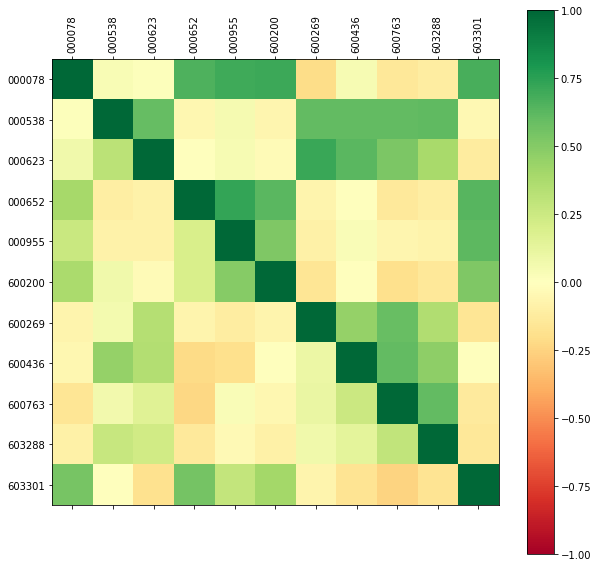

In [10]:
plot_corr(combine_corr_matrix(community_corr.close, community_corr.vol))

         name
ts_code      
000078   海王生物
000538   云南白药
000623   吉林敖东
000652   泰达股份
000955   欣龙控股
600200   江苏吴中
600269   赣粤高速
600436    片仔癀
600763   通策医疗
603288   海天味业
603301   振德医疗


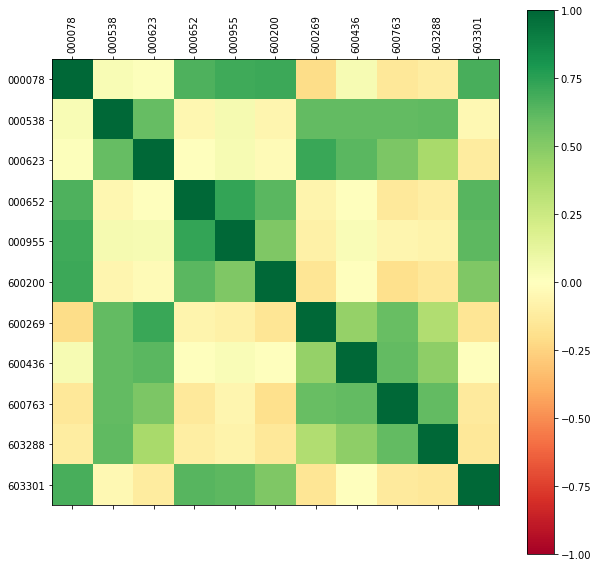

In [11]:
# Pearson correlation matrix for the close price between '2020-01-01' and '2020-06-30'
# Queried with ['000652', '000538'] = ['泰达股份', '云南白药'], and correlation threshold set as 0.6
# Resulted with 11 elements
plot_corr(community_corr.close)

In [12]:
%%time

community_corr = two_phase_hierarchical_clustering(community_corr)

CPU times: user 6.44 ms, sys: 882 µs, total: 7.32 ms
Wall time: 6.54 ms


         name
ts_code      
000955   欣龙控股
600200   江苏吴中
000078   海王生物
000652   泰达股份
603301   振德医疗
600763   通策医疗
603288   海天味业
000623   吉林敖东
600269   赣粤高速
000538   云南白药
600436    片仔癀


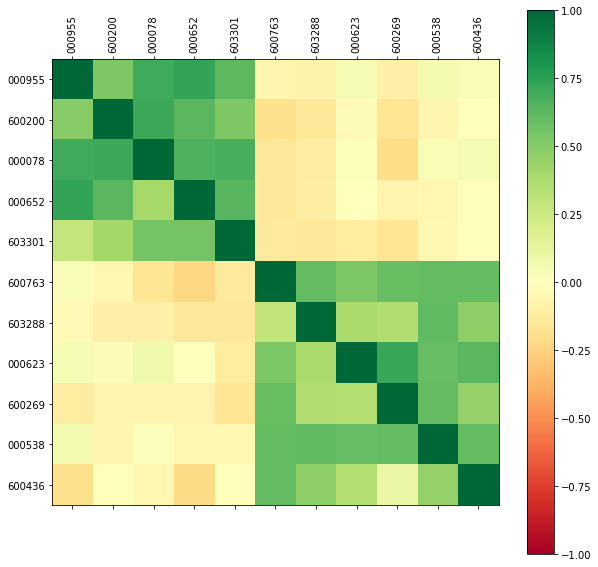

In [13]:
# Two phase hierarchical_clustering result, first base on close price (log return) then trading volume (log trading volume)
# With price as top-right, trading volume as bottom left
plot_corr(combine_corr_matrix(community_corr.close, community_corr.vol))

# 3. Knowledge list

In [14]:
industry_member_list = pd.read_csv('raw/industry_member_list.csv', parse_dates=['in_date']).rename(columns={'con_code': 'ts_code'})
industry_member_list.ts_code = industry_member_list.ts_code.apply(lambda x: x[:6])
industry_member_list = industry_member_list.merge(stock_info_list[['ts_code', 'list_date']])
industry_member_list = industry_member_list.merge(pd.read_csv('raw/industry_list.csv'))
industry_member_list = industry_member_list[['industry_code', 'industry_name', 'level', 'ts_code', 'in_date']]
if save:
    industry_member_list.to_feather('industry_member_list.ftr')

industry_list = industry_member_list[['industry_code', 'industry_name', 'level', 'ts_code']].groupby(['industry_code', 'industry_name', 'level']).count().reset_index()
industry_list.columns = ['industry_code', 'industry_name', 'level', 'count']
if save:
    industry_list.to_feather('industry_list.ftr')
    
index_industry_list = pd.read_csv('raw/index_industry_list.csv')[['ts_code', 'name', 'industry_code']]
index_industry_list.columns = ['in_code', 'name_c', 'industry_code']
index_name_input = pd.Series({
    '000986.SH': 'Energy',
    '000987.SH': 'Materials',
    '000988.SH': 'Industrials',
    '000989.SH': 'Consumer Discretionary',
    '000990.SH': 'Consumer Staples',
    '000991.SH': 'HealthCare',
    '000992.SH': 'Financials',
    '000993.SH': 'IT',
    '000994.SH': 'Telecom',
    '000995.SH': 'Utilities',
}, name='name')
index_industry_list = index_industry_list.merge(index_name_input, left_on='in_code', right_index=True)
if save:
    index_industry_list.to_feather('index_industry_list.ftr')

In [15]:
concept_member_list = pd.read_csv('raw/concept_member_list.csv')
concept_member_list.columns = ['concept_id', 'ts_code', 'name']
concept_member_list.ts_code = concept_member_list.ts_code.apply(lambda x: x[:6])
concept_member_list = concept_member_list.merge(stock_info_list['ts_code'])
if save:
    concept_member_list.to_feather('concept_member_list.ftr')

concept_list = pd.read_csv('raw/concept_list.csv')
concept_list = concept_list.merge(concept_member_list[['concept_id', 'ts_code']].groupby('concept_id').count(), left_on='ts_code', right_on='concept_id')
concept_list.columns = ['concept_id', 'name', 'list_date', 'count']
if save:
    concept_list.to_feather('concept_list.ftr')

# 4. Correlation of different timeframes

In [16]:
start_date = '2020-01-01'
end_date = '2020-06-30'
# start_date = '2011-01-01'
# end_date = '2020-12-31'
query_code = '000652'
# query_code = '000538'
# query_code = '603301'

display(stock_info_list.query('ts_code == @query_code'))

def plot_corr(df,size=10):    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.gca().xaxis.tick_bottom()
    plt.xticks(range(len(df.columns)), df.columns, rotation=-90);
    plt.yticks(range(len(df.index)), df.index);

def rolling_corr_market(query_code='000652', start_date='2020-01-01', end_date='2020-06-30'):
    # find appropriate window size
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum()
    window = int(max(1, trade_days/200))
    
    # filter stock price by timeframe
    index_price = index_daily_log[['000001.SH']].loc[start_date:end_date]
    stock_price = stock_daily_log.close[query_code].loc[start_date:end_date]
    index_stock_price = index_price.merge(stock_price, left_index=True, right_index=True)[::window]
    index_price = index_stock_price[index_stock_price.columns[0]]
    stock_price = index_stock_price[index_stock_price.columns[1]]
    
    # find individual corrlation with market
    pinus = {day: index_price.rolling(day, min_periods=1).corr(stock_price) for day in range(len(index_stock_price), 1, -1)}
    pinus = pd.DataFrame(pinus).round(4).replace([np.inf, -np.inf], np.nan)
    pinus.index = pinus.index.strftime('%Y-%m-%d')
    pinus = pinus.drop(index=pinus.index[0]).transpose() # round to 4dp and drop window size 1 because self correlation is always 1
    return pinus

def find_index_code(query_code='000652'):
    industry_code = industry_member_list.query('ts_code == @query_code and level == "L1"').industry_code.to_list()[0]
    return index_industry_list.query('industry_code == @industry_code').iloc[0]

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
210,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,NaN,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [17]:
%%time
pinus = rolling_corr_market(query_code, start_date, end_date)
pinus

CPU times: user 374 ms, sys: 2.73 ms, total: 377 ms
Wall time: 375 ms


trade_date,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-22,2020-06-23,2020-06-24,2020-06-29,2020-06-30
117,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0700
116,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0693
115,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0693,-0.0693
114,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0693,-0.0693,-0.0693
113,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0686,-0.0693,-0.0693,-0.0710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,-1.0,-0.5213,0.1801,0.7499,0.7730,0.9370,0.9154,0.8998,0.9248,0.9084,...,-0.4942,-0.6653,-0.6672,-0.7300,-0.8671,-0.8524,-0.5592,-0.3958,-0.6515,-0.4859
5,-1.0,-0.5213,0.1801,0.7499,0.9416,0.9476,0.9169,0.9469,0.8974,0.8302,...,-0.4033,-0.7027,-0.7969,-0.8479,-0.8632,-0.6415,-0.3942,-0.4384,-0.7848,-0.2352
4,-1.0,-0.5213,0.1801,0.9911,0.9499,0.9477,0.9917,0.8647,0.8345,0.8568,...,-0.4609,-0.8136,-0.9986,-0.8476,-0.5670,-0.4662,-0.4446,-0.6830,-0.7178,-0.1562
3,-1.0,-0.5213,0.9731,0.9922,0.9496,0.9996,0.9576,0.7624,0.9447,0.8174,...,-0.4241,-0.9993,-0.9997,-0.5440,-0.3845,-0.5107,-0.6828,-0.7748,-0.8642,-0.2442


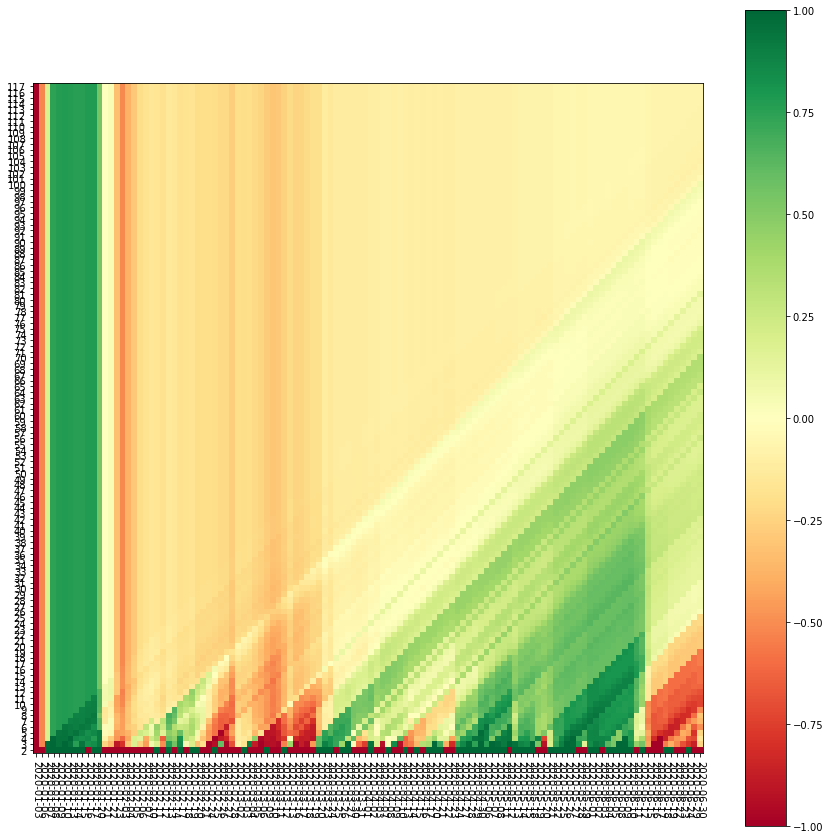

In [18]:
plot_corr(pinus, size=15)

pinus_output = {
    'date': pinus.columns.to_list(),
    'window': pinus.index.to_list(),
    'corr': [i for num, row in pinus.iterrows() for i in row.fillna(2).to_list()[-(len(pinus)+2-num):]]
}
# with open('../../client/src/components/pinus.json', 'w+') as file:
#     simplejson.dump(pinus_output, file, ignore_nan=True)

# pinus_output

In [19]:
triangle = [i for i in range(5*3)]
display(triangle)
K = [int((math.sqrt(8*(i)+1)-1)/2) for i in triangle]
display(K)
b = [(i-int((k)*(k+1)/2)) for i, k in enumerate(K)]
display(b)
ind = [(x, y, math.floor((y+1)*(y+2)/2)-1-x) for y in range(5) for x in range(y+1)]
display(ind)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

[0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4]

[(0, 0, 0),
 (0, 1, 2),
 (1, 1, 1),
 (0, 2, 5),
 (1, 2, 4),
 (2, 2, 3),
 (0, 3, 9),
 (1, 3, 8),
 (2, 3, 7),
 (3, 3, 6),
 (0, 4, 14),
 (1, 4, 13),
 (2, 4, 12),
 (3, 4, 11),
 (4, 4, 10)]

# 5. Knowledge graph network

In [113]:
### Human: Management ###

stk_managers_list = pd.read_csv('raw/stk_managers_list.csv')[['ts_code', 'name', 'title', 'birthday']]
stk_managers_list.ts_code = stk_managers_list.ts_code.apply(lambda x: x[:6])
stk_managers_list = stk_managers_list.merge(stock_info_list.ts_code) # filter to mainboard
stk_managers_list.birthday = stk_managers_list.birthday.fillna(0).apply(lambda x: x if x < 2100 else x/100).apply(lambda x: x if x < 2000 else x/100).astype(int) # clean birthday
stk_managers_list = stk_managers_list.groupby(['name', 'birthday', 'ts_code']).agg(list).reset_index() # aggregate the title information
if save:
    stk_managers_list.to_feather('stk_managers_list.ftr')

stk_managers_edges = [
    {'node': managers[2], 'edge': managers[0]} 
    for managers in stk_managers_list.drop('title', axis=1).groupby(['name', 'birthday']).agg(list).reset_index().values
    if len(managers[2]) > 1
]
stk_managers_edges[1]

{'node': ['000779', '600272'], 'edge': 'Charlie Chang'}

In [111]:
### Human: Investors ###

stk_holders_list = pd.read_csv('raw/stk_holders_list.csv')
stk_holders_list.ts_code = stk_holders_list.ts_code.apply(lambda x: x[:6])
stk_holders_list.holder_name = stk_holders_list.holder_name.str.replace('#', '')
stk_holders_list = stk_holders_list[stk_holders_list.duplicated(['ts_code', 'holder_name'], keep=False)]
stk_holders_list = stk_holders_list.drop('ann_date', axis=1).groupby(['ts_code', 'holder_name']).agg(list).reset_index()
if save:
    stk_holders_list.to_feather('stk_holders_list.ftr')

stk_holders_edges = [
    {'node': holders[1], 'edge': holders[0]} 
    for holders in stk_holders_list[['ts_code', 'holder_name']].groupby('holder_name').agg(list).reset_index().values
    if len(holders[1]) > 1
]
stk_holders_edges[0]

{'node': ['000012', '000488', '000539', '001872'],
 'edge': 'BBH A/C VANGUARD EMERGING MARKETS STOCK INDEX FUND'}

In [110]:
### Business: Industries ###

industry_edges = [
    {'node': industry[2], 'edge': industry[1]+'-'+industry[0]} 
    for industry in industry_member_list[['industry_name', 'level', 'ts_code']].groupby(['industry_name', 'level']).agg(list).reset_index().values
    if len(industry[2]) > 1
]
industry_edges[2]

{'node': ['000861', '000882', '603682', '000007'], 'edge': 'L3-一般物业经营'}

In [115]:
### Business: Concepts ###

concept_edges = [
    {'node': concept[1], 'edge': concept[0]} 
    for concept in concept_list.merge(concept_member_list.drop('name', axis=1))[['name', 'ts_code']].groupby('name').agg(list).reset_index().values
    if len(concept[1]) > 1
]
concept_edges[4]

{'node': ['000821', '600438', '600546', '601137', '603396'], 'edge': 'HIT电池'}

In [117]:
### Business: Main Business ###

fina_mainbz = pd.read_csv('raw/fina_mainbz.csv')
fina_mainbz.ts_code = fina_mainbz.ts_code.apply(lambda x: x[:6])
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('\(|\)|（|）|-|\"|、|:|#|\'| |/|%|″|、|\u3000', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('主营|其他|其它|地区|区域|销售|服务|收入|产品|行业|产业|业务|企业|及|代理|托管|受托', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('业$|手续费|利息|类$|.*[子母]公司.*', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('^\d*$', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('.*[重组及之]*前.*|公司$|相关$|系列$|与', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('[东南西北境区以山广除内外华中国大陆]*$', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('^[行工商光物劳云农类新老印种副化二一省热辅管果内门专线实产海防和险三I政附会企态旅港保性KV梁财洲]$', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('[东南西北区以除内陕外华中国大陆美江河海上下京]*$', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('[非青韩浙德]$', '', regex=True)
fina_mainbz.bz_item = fina_mainbz.bz_item.str.replace('内部抵销|佣金', '', regex=True)
fina_mainbz = fina_mainbz.query('bz_item != ""').reset_index(drop=True)
if save:
    fina_mainbz.to_feather('fina_mainbz.ftr')

fina_mainbz_edges = [
    {'node': mainbz[1], 'edge': mainbz[0]} 
    for mainbz in fina_mainbz[['ts_code', 'bz_item']].drop_duplicates().groupby('bz_item').agg(list).reset_index().values
    if len(mainbz[1]) > 1
]
fina_mainbz_edges[0]

{'node': ['000620', '603353'], 'edge': '0柴油'}

In [118]:
### Location: Province and city ###

province_edges = [
    {'node': province[1], 'edge': province[0]} 
    for province in stock_info_list[['ts_code', 'province']].groupby('province').agg(list).reset_index().values
    if len(province[1]) > 1
]
city_edges = [
    {'node': city[1], 'edge': city[0]} 
    for city in stock_info_list[['ts_code', 'city']].groupby('city').agg(list).reset_index().values
    if len(city[1]) > 1
]
city_edges[1]

{'node': ['000663', '000732'], 'edge': '三明市'}

In [192]:
### Knowledge Graph ###

G = nx.Graph()
stock_info_dict = stock_info_list[['ts_code', 'name', 'industry', 'area']].set_index('ts_code').to_dict(orient='index')
G.add_nodes_from([(stock, stock_info_dict[stock]) for stock in stock_info_list.ts_code.values])

edge_sets = [
    (city_edges, 'city'), 
    (province_edges, 'province'), 
    (industry_edges, 'industry'), 
    (concept_edges, 'concept'), 
    (fina_mainbz_edges, 'mainbz'), 
    (stk_holders_edges, 'investor'), 
    (stk_managers_edges, 'management')
]

for edge_set, set_name in edge_sets:
    for edge in edge_set:
        for n1, n2 in itertools.combinations(edge['node'], 2):
            if n2 not in G[n1]:
                G.add_edge(n1, n2)
            if set_name not in G[n1][n2]:
                G[n1][n2][set_name] = [edge['edge']]
            else:
                G[n1][n2][set_name] = G[n1][n2][set_name]+[edge['edge']]
                
print(G.number_of_nodes(), G.number_of_edges())

2006 1154137


In [193]:
G['000001']['000002']

{'city': ['深圳市'],
 'province': ['广东'],
 'concept': ['MSCI概念', '标普道琼斯A股', '沪深300样本股', '深股通', '融资融券'],
 'mainbz': ['广州', '深圳'],
 'investor': ['中国证券金融股份有限公司', '中央汇金资产管理有限责任公司', '香港中央结算有限公司(陆股通)'],
 'management': ['孙建一', '康典']}

In [199]:
nx.write_gpickle(G, 'knowledge_graph.pkl')